## Business Objective

1. To understand the impact of markdowns to sales on a per SKU and per transaction/basket level;
2. To understand if markdowns would impact overall store sales;
3. To understand what products tend to respond to markdowns the most, and which ones don't; 
4. To understand cross-sell and up-sell opportunities.


<br>

## Process: 
- <a href='#1'>Look At Data First </a>
 - <a href='#1_1'>How the entire dateset is organized?</a>
 - <a href='#3'>Explore cases when Count=0</a>
 - <a href='#4'>Explore cases when Count=-1</a>
 - <a href='#1_2'>How many different behaviors we can observe within a transaction?</a>
- <a href='#2'>Cleaning Dirty Data and Finding Outliers </a>
 - <a href='#6'>Create a column indicating whether a SKU is a regular return, orphan return</a> **(Check 'Return Types.ipynb')**
 - <a href='#7'>Check Missing Values</a>
 - <a href='#8'>Explore Anomalies</a>
  - <a href='#81'>Calculate Discount Rate on a per transaction and per sku basis </a> **(Check 'Discount Rate.ipynb')**
 - <a href='#82'>Explore Outliers</a>
- <a href='#80'>Exploratory Data Analysis</a>  **(Check 'EDA.ipynb')**
- <a href='#90'>Actual Analysis </a>
 - <a href='#9'>1. What is the impact of markdowns to sales on a per transaction level? </a>
 - <a href='#110'>2. How promotion strategy impacts sales on a per store basis? </a>
 - <a href='#10'>3. If a product is discounted across different stores, how are you going to evaluate the promotion strategy?</a>
 - <a href='#11'>4. Can we find any cross-sell and up-sell opportunites?</a>
 - <a href='#12'>5. How about the time or day of promotion? Would that make a difference?</a>
 - <a href='#13'>6. Look at low end and high end products separately when evaluating promotion strategy</a>
 
 




<br>

## Look At Data First	<a name='1' />


In [11]:
import pandas as pd
from datetime import datetime

In [12]:
start_time = datetime.now()
data = pd.read_csv('RetailerPromotionStrategy_data.csv')
print datetime.now()-start_time

0:00:01.360275


In [74]:
data.head()

,StoreID,TransactionID,Line,Sales,Count,Date,SKU
0,A29,11-7270-00007-00057,36,850.0,1.0,3/11/12 00:00,A21773
1,A29,11-7270-00007-00057,39,1500.0,1.0,3/11/12 00:00,A18009
2,A29,11-7270-00007-00057,40,1500.0,1.0,3/11/12 00:00,A25592
3,A29,11-7270-00007-00057,41,1600.0,1.0,3/11/12 00:00,A1449
4,A29,11-7270-00007-00057,42,1600.0,1.0,3/11/12 00:00,A1449


### How the entire dateset is organized? <a name='1_1' />

In [14]:
print 'Shape of dataset: {0}'.format(data_type.shape)
print 'Number of unique stores: {0}'.format(len(data_type.StoreID.unique()))
print 'Number of unique transactions: {0}'.format(len(data_type.TransactionID.unique()))
print 'Number of unique dates: {0}'.format(len(data_type.Date.unique()))
print 'Number of unique SKUs: {0}'.format(len(data_type.SKU.unique()))

Shape of dataset: (1041577, 8)
Number of unique stores: 73
Number of unique transactions: 192963
Number of unique dates: 2
Number of unique SKUs: 15179


- There are total 1M rows and 7 features in the dataset. Among the data, there are 73 unique stores, 15K unique SKUs, and 200K unique transactions.

- The records are organized on a SKU level by each transaction within each store, for each day.


### Explore cases when Count=0 <a name='3' />

In [42]:
data_count0 = data[data['Count']==0]

data_count0.head(3)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU
12,A29,11-7270-00007-00057,63,-786.0,0.0,3/11/12 00:00,A256
14,A29,11-7270-00007-00057,65,-770.0,0.0,3/11/12 00:00,A8481
20,A29,11-7270-00007-00057,75,-500.0,0.0,3/11/12 00:00,A2341


In [24]:
data.loc[(data['SKU']=='A256')&(data['TransactionID']=='11-7270-00007-00057')]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU
11,A29,11-7270-00007-00057,62,2095.0,1.0,3/11/12 00:00,A256
12,A29,11-7270-00007-00057,63,-786.0,0.0,3/11/12 00:00,A256


When Count=0, it means it's a discount applied to the purchase

In [23]:
# Why there are rows where Count=0 but Sales>0?
data.loc[(data['Count']==0)&(data['Sales']>0)].head(3)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU
1161,A29,11-7270-00007-00110,29,845.0,0.0,3/11/12 00:00,A6007
1234,A29,11-7270-00007-00116,20,234.0,0.0,3/11/12 00:00,A2452
4065,A29,11-7270-00008-00358,6,670.0,0.0,3/11/12 00:00,A13774


In [22]:
data[(data.TransactionID=='11-7270-00007-00110')&(data.SKU=='A6007')][4:]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU
1158,A29,11-7270-00007-00110,26,2195.0,1.0,3/11/12 00:00,A6007
1159,A29,11-7270-00007-00110,27,-845.0,0.0,3/11/12 00:00,A6007
1160,A29,11-7270-00007-00110,28,-2195.0,-1.0,3/11/12 00:00,A6007
1161,A29,11-7270-00007-00110,29,845.0,0.0,3/11/12 00:00,A6007


We know from the above table: The positive sales amount is basically the credit back to the store for the discount extended to the customer earlier.

### Explore cases when Count=-1 <a href='#4'>

In [66]:
# Count=-1
data.loc[data['Count']==-1].head()

,StoreID,TransactionID,Line,Sales,Count,Date,SKU
100,A29,11-7270-00007-00066,5,-2013.000,-1.000,3/11/12 00:00,A2729
354,A19,11-7287-00025-00075,4,-1721.000,-1.000,3/11/12 00:00,A16911
446,A27,11-7069-00020-00010,6,-4252.000,-1.000,3/11/12 00:00,A7293
458,A29,11-7270-00007-00072,37,-2395.000,-1.000,3/11/12 00:00,A19365
622,A29,11-7270-00007-00089,19,-3995.000,-1.000,3/11/12 00:00,A21166


In [16]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [26]:
q = '''
    select
        d1.StoreID, d1.TransactionID, d1.Line, d1.Sales, d1.Count, d1.Date, d1.SKU
    from 
        data d1
    inner join
        (select 
            TransactionID, SKU
        from
            data
        where Count=-1) as d2
    on 
        d1.TransactionID = d2.TransactionID and
        d1.SKU = d2.SKU
    '''
data2 = pysqldf(q)

In [27]:
data2.head(10)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU
0,A29,11-7270-00007-00066,3,2013.0,1.0,3/11/12 00:00,A2729
1,A29,11-7270-00007-00066,4,2013.0,1.0,3/11/12 00:00,A2729
2,A29,11-7270-00007-00066,5,-2013.0,-1.0,3/11/12 00:00,A2729
3,A19,11-7287-00025-00075,3,1721.0,1.0,3/11/12 00:00,A16911
4,A19,11-7287-00025-00075,4,-1721.0,-1.0,3/11/12 00:00,A16911
5,A27,11-7069-00020-00010,1,4252.0,1.0,3/11/12 00:00,A7293
6,A27,11-7069-00020-00010,6,-4252.0,-1.0,3/11/12 00:00,A7293
7,A29,11-7270-00007-00072,33,2395.0,1.0,3/11/12 00:00,A19365
8,A29,11-7270-00007-00072,35,2395.0,1.0,3/11/12 00:00,A19365
9,A29,11-7270-00007-00072,36,2395.0,1.0,3/11/12 00:00,A19365


We can see from the table, ‘count=-1’ means the customer returned the item just bought or it could be a promotion strategy like buy 1 get 1 free. In this analysis, I treated it as a return.


### How many different behaviors we can observe within a transaction? <a name='1_2'>

Within a transaction, there are only 3 behaviors which we will observe:   
1. Purchase item(s) at the regular price;   
2. Purchase item(s) at a discount;   
3. Return item(s) that were purchased either within the same transaction, or from a prior transaction.


<br><br>

## Cleaning Dirty Data and Finding Outliers <a name='2'/>

### Create a column indicating whether a SKU is a regular return, orphan return<a name='6' />

Please **check 'Return Types.ipynb'** to see how I filter out regular returns and orphan returns. And then I create a new column next to the raw dataset and indicate whether a SKU is a regular return, orphan return, regular return credit back, or orphan return credit back. This will allow us to easily manipulate the records on a row level, SKU level, or transaction level, depending on what our analysis needs are. For example, everytime, when there is an orphan return, we simply exclude them when calculating sales per transaction. If it is a regular return, we leave them be as they will cancel each other out.


In [29]:
data_type = pd.read_csv('type.csv')
data_type.fillna('',inplace=True)

In [302]:
data_type.shape

(1048575, 8)

In [303]:
data_type[data_type.TransactionID=='11-7270-00007-00066'][:4]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
97,A29,11-7270-00007-00066,1,300.000,1.000,3/11/12 00:00,A21771,
98,A29,11-7270-00007-00066,3,2013.000,1.000,3/11/12 00:00,A2729,
99,A29,11-7270-00007-00066,4,2013.000,1.000,3/11/12 00:00,A2729,
100,A29,11-7270-00007-00066,5,-2013.000,-1.000,3/11/12 00:00,A2729,Regular_Return


In [304]:
data_type[data_type.TransactionID=='11-7270-00012-00154']

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
5035,A29,11-7270-00012-00154,2,-17475.000,-5.000,3/11/12 00:00,A6386,Orphan_Return
5036,A29,11-7270-00012-00154,3,10000.000,5.000,3/11/12 00:00,A6386,


In [30]:
data_type[(data_type.TransactionID=='12-7081-00015-00118')&(data_type.SKU=='A5483')]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
485387,A33,12-7081-00015-00118,2,-33990.0,-2.0,3/12/12 00:00,A5483,Orphan_Return
485388,A33,12-7081-00015-00118,3,21000.0,0.0,3/12/12 00:00,A5483,CreditBack_OrphanReturn
485390,A33,12-7081-00015-00118,5,-16995.0,-1.0,3/12/12 00:00,A5483,Orphan_Return
485391,A33,12-7081-00015-00118,6,10500.0,0.0,3/12/12 00:00,A5483,CreditBack_OrphanReturn
485393,A33,12-7081-00015-00118,9,6495.0,1.0,3/12/12 00:00,A5483,
485394,A33,12-7081-00015-00118,10,-16995.0,-1.0,3/12/12 00:00,A5483,Orphan_Return


<br><br>

### Check Missing Values <a name='7' />

In [31]:
data_type.isnull().sum()

StoreID          0
TransactionID    0
Line             0
Sales            0
Count            0
Date             0
SKU              0
Type             0
dtype: int64

<br><br>

### Explore Anomalies <a name='8' />

In [192]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
data_type.describe()

,Line,Sales,Count
count,1048575.000,1048575.000,1048575.000
mean,10.727,1720.513,0.896
std,15.550,3646.003,1.129
min,1.000,-99995.000,-120.000
25%,3.000,395.000,1.000
50%,7.000,1295.000,1.000
75%,14.000,2195.000,1.000
max,823.000,99995.000,120.000


#### Scenario 1: When count is a decimal point and sales=0


In [193]:
data_type[(data_type.Sales==0) & (data_type.Count<1) & (data_type.Count>0)]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
19710,A65,11-3571-00002-00495,7,0.000,0.020,3/11/12 00:00,A10522,
20406,A65,11-3571-00001-00205,22,0.000,0.020,3/11/12 00:00,A10522,
99018,A06,12-6997-00005-00028,3,0.000,0.010,3/12/12 00:00,A4945,
816024,A65,12-3572-00001-00033,15,0.000,0.020,3/12/12 00:00,A10522,
817574,A65,12-3572-00001-00305,9,0.000,0.020,3/12/12 00:00,A10522,


In [305]:
data_type.drop(data_type[(data_type.Sales==0) & (data_type.Count<1) & (data_type.Count>0)].index,inplace=True)

There are 5 rows where count is a decimal point and sales=0.    
Treatment: We can safely filter these rows out from our analysis.

#### Scenario 2: When Count=0 and Sales=0

In [195]:
data_type[(data_type.Sales==0) & (data_type.Count==0)].head(2)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
387,A27,11-7069-00019-00010,3,0.000,0.000,3/11/12 00:00,A25083,
388,A27,11-7069-00019-00010,4,0.000,0.000,3/11/12 00:00,A14671,


In [196]:
data_type[(data_type.Sales==0) & (data_type.Count==0)].shape

(3223, 8)

In [306]:
data_type.drop(data_type[(data_type.Sales==0) & (data_type.Count==0)].index,inplace=True)

There are 3223 rows where count=0 and sales=0.    
Treatment: We can safely filter these rows out from our analysis.

#### Scenario 3: Orphan Return - returns with no matching purchase within the same transaction / returned an item purchased earlier at the regular price, AND purchased the same item at discounted price

In [220]:
data_type[(data_type.TransactionID=='11-7270-00012-00190')]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
5050,A29,11-7270-00012-00190,1,-18995.000,-1.000,3/11/12 00:00,A10981,Orphan_Return
5051,A29,11-7270-00012-00190,2,-7995.000,-1.000,3/11/12 00:00,A21473,Orphan_Return


In [221]:
data_type[(data_type.TransactionID=='12-7081-00015-00118')&(data_type.SKU=='A5483')]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
485387,A33,12-7081-00015-00118,2,-33990.000,-2.000,3/12/12 00:00,A5483,Orphan_Return
485388,A33,12-7081-00015-00118,3,21000.000,0.000,3/12/12 00:00,A5483,CreditBack_OrphanReturn
485390,A33,12-7081-00015-00118,5,-16995.000,-1.000,3/12/12 00:00,A5483,Orphan_Return
485391,A33,12-7081-00015-00118,6,10500.000,0.000,3/12/12 00:00,A5483,CreditBack_OrphanReturn
485393,A33,12-7081-00015-00118,9,6495.000,1.000,3/12/12 00:00,A5483,
485394,A33,12-7081-00015-00118,10,-16995.000,-1.000,3/12/12 00:00,A5483,Orphan_Return


In [307]:
orphan = data_type[(data_type.Type=='Orphan_Return')|(data_type.Type=='CreditBack_OrphanReturn')]

In [235]:
orphan.head()

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
5003,A29,11-7270-00012-00113,2,-17990.000,-2.000,3/11/12 00:00,A22728,Orphan_Return
5021,A29,11-7270-00012-00126,1,-3500.000,-1.000,3/11/12 00:00,A24521,Orphan_Return
5035,A29,11-7270-00012-00154,2,-17475.000,-5.000,3/11/12 00:00,A6386,Orphan_Return
5040,A29,11-7270-00012-00167,2,-54000.000,-1.000,3/11/12 00:00,A1149,Orphan_Return
5045,A29,11-7270-00012-00174,2,-11985.000,-3.000,3/11/12 00:00,A25628,Orphan_Return


In [236]:
print data_type.shape
print orphan.shape
print len(orphan.TransactionID.unique())

(1045347, 8)
(3651, 8)
2813


In [308]:
# Drop rows with orphan returns
data_type = pd.merge(data_type,orphan,on=['StoreID','TransactionID','Line','Sales','Count','Date','SKU','Type'],how='left',indicator=True)
data_type = data_type[data_type['_merge']=='left_only']

In [309]:
data_type.drop('_merge',1,inplace=True)

In [264]:
data_type.head(3)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
0,A29,11-7270-00007-00057,36,850.000,1.000,3/11/12 00:00,A21773,
1,A29,11-7270-00007-00057,39,1500.000,1.000,3/11/12 00:00,A18009,
2,A29,11-7270-00007-00057,40,1500.000,1.000,3/11/12 00:00,A25592,


In [265]:
data_type.shape

(1041696, 8)

There are 3651 rows exhibit orphan returns(include credit back for orphan returns) and 2813 transactions exhibit orphan return.  

Treatment: Everytime, when there is an orphan return, we simply exclude them when calculating sales per transaction. If it is a regular return, we leave them be as they will cancel each other out.

In [310]:
data_type.to_csv('data_type.csv', sep=',',index=False)

<br><br>

### Calculate Discount Rate on a per transaction and per sku basis <a name='81' />

Given that we calculate discounts on a per transaction and per sku basis, all we need to do is to sum up the sales and discounts to calculate the discount rate. (**Check 'Discount Rate.ipynb'**)  

Since the total sales per SKU per transaction can not be negative. With that in mind, we can just filter out these rows, and the rest, just keep them there as we have no reference as to whether a steep discount rate such as 85% is valid. For now, let's assume they are.



In [2]:
import pandas as pd

In [32]:
data_type = pd.read_csv('data_type.csv')
data_type.fillna('',inplace=True)

In [4]:
data_type.shape

(1041577, 8)

In [313]:
data_type.head(3)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
0,A29,11-7270-00007-00057,36,850.000,1.000,3/11/12 00:00,A21773,
1,A29,11-7270-00007-00057,39,1500.000,1.000,3/11/12 00:00,A18009,
2,A29,11-7270-00007-00057,40,1500.000,1.000,3/11/12 00:00,A25592,


<br><br>

### Explore Outliers <a name='82' />

In [314]:
df = data_type[data_type.Count>0]
df['Unit Price'] = df['Sales'] / df['Count']

/Users/Frank/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [315]:
df.describe()

,Line,Sales,Count,Unit Price
count,867714.000,867714.000,867714.000,867714.000
mean,10.252,2298.513,1.097,2208.372
std,14.552,3532.143,1.101,3309.162
min,1.000,1.000,1.000,0.015
25%,2.000,895.000,1.000,821.000
50%,6.000,1595.000,1.000,1502.000
75%,13.000,2495.000,1.000,2413.000
max,822.000,99995.000,120.000,99995.000


In [316]:
# Check outliers as a reference
import numpy as np
def find_outliers_tukey(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    iqr = q3 - q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor) | (x > ceiling)])
    outlier_values = list(x[outlier_indices])
    
    return outlier_indices, outlier_values

In [317]:
# Outliers on SKU level
np.set_printoptions(formatter={'float_kind':lambda x: "%.2f" % x})
outlier_var = ['Unit Price']
for x in outlier_var:
    tukey_indices, tukey_values = find_outliers_tukey(df[x])
    a = np.sort(tukey_values)
    print "Feature '{0}' outliers (part)：{1} & {2}\n".format(x,np.unique(a)[:10],np.unique(a)[-10:])
    print "Number of outliers: {0}\n".format(len(tukey_values))

Feature 'Unit Price' outliers (part)：[4810.00 4813.00 4833.00 4835.00 4845.00 4850.00 4875.00 4895.00 4896.00
 4900.00] & [74900.00 79900.00 80000.00 84995.00 85900.00 86900.00 89900.00 94900.00
 99900.00 99995.00]

Number of outliers: 67154



In [318]:
data_type[data_type.TransactionID=='11-7270-00007-00223']

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
4793,A29,11-7270-00007-00223,1,99900.000,1.000,3/11/12 00:00,A21288,
6491,A29,11-7270-00007-00223,11,6303.000,1.000,3/11/12 00:00,A25455,
6492,A29,11-7270-00007-00223,12,725.000,1.000,3/11/12 00:00,A16206,


**Treatment:** Leave outliers there as there is no reference for us to say they are not valid, so let's just assume they are.

<br><br>

## Exploratory Data Analysis <a name='80'/>

Please check **'EDA.ipynb'**

<br><br>

## Actual Analysis <a name='90'/>

### 1. What is the impact of markdowns to sales on a per transaction level? <a name='9' />

**Metrics:** Average sales per basket on transactions with discounted items and transactions without discounted items across all stores

**Calculation Method:** 'Sum of sales / number of transactions' for  transactions with discounted items, and transactions without discounted items across the stores. And then compare the average sales per basket. (When there is an orphan return, we simply exclude them when calculating sales per transaction)
 


In [319]:
data_type.head()

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
0,A29,11-7270-00007-00057,36,850.000,1.000,3/11/12 00:00,A21773,
1,A29,11-7270-00007-00057,39,1500.000,1.000,3/11/12 00:00,A18009,
2,A29,11-7270-00007-00057,40,1500.000,1.000,3/11/12 00:00,A25592,
3,A29,11-7270-00007-00057,41,1600.000,1.000,3/11/12 00:00,A1449,
4,A29,11-7270-00007-00057,42,1600.000,1.000,3/11/12 00:00,A1449,


In [320]:
len(data_type.TransactionID.unique())

192963

In [34]:
# Select transactions with discounted items 
q='''
  select
      a.*
  from
      data_type a
  inner join
      (select distinct TransactionID
       from data_type
       where Count=0) b
  on
      a.TransactionID=b.TransactionID 
  '''
data50= pysqldf(q)

In [37]:
len(data50.StoreID.unique())

73

In [38]:
# Select transactions with discounted items 
q='''
  select
      a.StoreID,
      a.TransactionID,
      sum(a.Count) as Counts,
      sum(a.Sales) as Total
  from
      data_type a
  inner join
      (select distinct TransactionID
       from data_type
       where Count=0) b
  on
      a.TransactionID=b.TransactionID
  group by
      a.TransactionID
  order by
      a.TransactionID  
  '''
data51= pysqldf(q)

In [39]:
data51.head()

,StoreID,TransactionID,Counts,Total
0,A60,11-0160-00019-00003,10.0,3500.0
1,A60,11-0160-00019-00007,15.0,5000.0
2,A60,11-0160-00019-00008,15.0,5000.0
3,A60,11-0160-00019-00010,11.0,5000.0
4,A60,11-0160-00019-00011,16.0,7195.0


In [40]:
data51[data51.Total<=0].head()

,StoreID,TransactionID,Counts,Total


In [326]:
data_type[data_type.TransactionID=='11-5634-00024-00094']

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
47878,A78,11-5634-00024-00094,5,6995.000,1.000,3/11/12 00:00,A11213,
47879,A78,11-5634-00024-00094,6,-4495.000,0.000,3/11/12 00:00,A11213,
47880,A78,11-5634-00024-00094,7,6995.000,1.000,3/11/12 00:00,A11213,
47881,A78,11-5634-00024-00094,8,-4495.000,0.000,3/11/12 00:00,A11213,


In [328]:
# Average sales per basket (there are discount items in transactions)
avg_rev_discount = data51.Total.sum() / data51.TransactionID.size

print 'Average sales per basket for those transactions include discounted items is {0}.'.format(avg_rev_discount)

Average sales per basket for those transactions include discounted items is 14412.4469103.


In [26]:
# Average sales per basket in different store
# avg_rev_discount_store = data50.groupby('StoreID').Total.sum() / data50.groupby('StoreID').TransactionID.size()

In [332]:
data50.head()

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
0,A29,11-7270-00007-00057,36,850.000,1.000,3/11/12 00:00,A21773,
1,A29,11-7270-00007-00057,39,1500.000,1.000,3/11/12 00:00,A18009,
2,A29,11-7270-00007-00057,40,1500.000,1.000,3/11/12 00:00,A25592,
3,A29,11-7270-00007-00057,41,1600.000,1.000,3/11/12 00:00,A1449,
4,A29,11-7270-00007-00057,42,1600.000,1.000,3/11/12 00:00,A1449,


In [41]:
#Drop transactions with discounts
data52 = pd.merge(data_type,data50,on=['StoreID','TransactionID','Line','Sales','Count','Date','SKU','Type'],how='left',indicator=True)
data52 = data52[data52['_merge']=='left_only']
data52.drop('_merge',1,inplace=True)

In [42]:
print data_type.shape
print data50.shape
print data52.shape
print len(data51.TransactionID.unique())
print len(data52.TransactionID.unique())

(1041577, 8)
(636727, 8)
(404850, 8)
61078
131885


In [339]:
# Select transactions where there no discounted items 
q='''
  select
      StoreID,
      TransactionID,
      sum(Count) as Counts,
      sum(Sales) as Total
  from
      data52 
  group by
      TransactionID
  order by
      TransactionID  
  '''
data53= pysqldf(q)

In [340]:
data53.head(3)

,StoreID,TransactionID,Counts,Total
0,A60,11-0160-00019-00029,1.000,2000.000
1,A60,11-0160-00019-00031,1.000,1875.000
2,A60,11-0160-00021-00008,1.000,2195.000


In [342]:
# Average sales per basket (there aren't any discount items in transactions)
avg_rev_discount1 = data53.Total.sum() / data53.TransactionID.size

print 'Average sales per basket for those transactions include non-discounted items is {0}.'.format(avg_rev_discount1)

Average sales per basket for those transactions include non-discounted items is 7245.54336692.


In [22]:
# Average sales per basket without discount items in different store
# avg_rev_discount_store1 = data52.groupby('StoreID').Total.sum() / data52.groupby('StoreID').TransactionID.size()

In [57]:
# Visualization
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

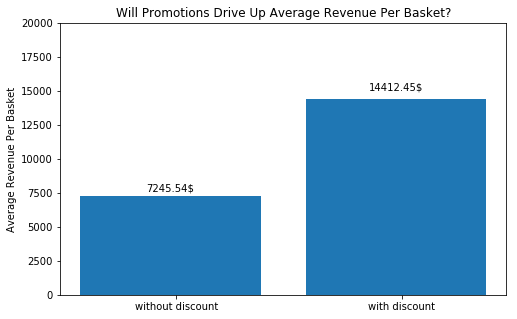

In [347]:
fig, ax = plt.subplots(figsize=(8,5))
x=np.arange(2)
width=0.05
rects1 = ax.bar(x,[avg_rev_discount1,avg_rev_discount])
ax.set_ylabel('Average Revenue Per Basket')
ax.set_ylim(0,20000)
ax.set_title('Will Promotions Drive Up Average Revenue Per Basket?')
ax.set_xticks(x+width/2 )
ax.set_xticklabels(('without discount','with discount'))
#annotate
def autolabel(rects):
    for rect in rects:
        height=rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2, 1.035*height, '{:.2f}$'.format(height), ha='center', va='bottom')
autolabel(rects1)

According to the above plot, we can conclude that promotions will drive up average sales per basket.

<br><br>

### 2. How promotion strategy impacts sales on a per store basis? <a name='110' />

**Metrics:** Average sales per basket on transactions with discounted items and transactions without discounted items for SPECIFIC STORE

**Calculation Method:** For specific store, calculate 'Sum of sales / number of transactions' for transactions with discounted items, and transactions where there are no discounted. (when there is an orphan return, we simply exclude them when calculating sales per transaction)


In [50]:
# Select transactions with discounted items for specific store
q='''
  select
      StoreID,
      sum(Sales) as Total,
      count(distinct TransactionID) as Number_of_Transactions,
      sum(Sales)/count(distinct TransactionID) as 'Average sales per basket (with discounts)'
  from
      data50
  group by
      StoreID
  
  '''
data70= pysqldf(q)

In [54]:
# Select transactions with discounted items for specific store
q='''
  select
      StoreID,
      sum(Sales) as Total,
      count(distinct TransactionID) as Number_of_Transactions,
      sum(Sales)/count(distinct TransactionID) as 'Average sales per basket (without discounts)'
  from
      data52
  group by
      StoreID
  
  '''
data71= pysqldf(q)

In [55]:
data70.head(3)

,StoreID,Total,Number_of_Transactions,Average sales per basket (with discounts)
0,A01,11753538.0,1119,10503.608579
1,A02,8924445.0,515,17329.019417
2,A03,9940988.0,614,16190.534202


In [72]:
data71.head(3)

,StoreID,Total,Number_of_Transactions,Average sales per basket (without discounts)
0,A01,1.225755e+07,2323,5276.603099
1,A02,1.086761e+07,1212,8966.671616
2,A03,8.835739e+06,1145,7716.802270


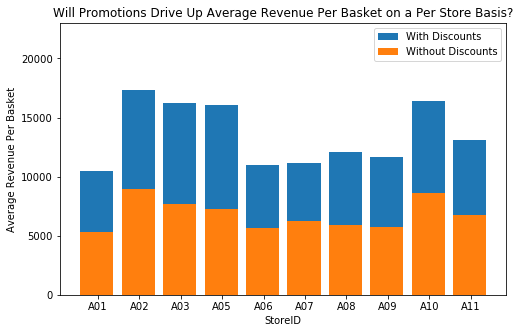

In [73]:
fig, ax = plt.subplots(figsize=(8,5))
x=np.arange(10)
width=0.05
rects1 = ax.bar(x,data70['Average sales per basket (with discounts)'][:10])
rects2 = ax.bar(x,data71['Average sales per basket (without discounts)'][:10])
ax.set_ylabel('Average Revenue Per Basket')
ax.set_xlabel('StoreID')
ax.set_ylim(0,23000)
ax.set_title('Will Promotions Drive Up Average Revenue Per Basket on a Per Store Basis?')
ax.set_xticks(x+width/2)
ax.set_xticklabels(('A01','A02','A03','A05','A06','A07','A08','A09','A10','A11'))
ax.legend((rects1[0],rects2[0]),('With Discounts','Without Discounts'))

According to the above plot, promotions will drive up average revenue per basket on a per store basis.

<br><br>

### 3. If a product is discounted across different stores, how are you going to evaluate the promotion strategy?
 <a name='10' />


**Metrics:** Elasticity of Demand for specific SKU across stores

**Calculation Method:** Percent change in demand for specific SKU before and after discount / Percent change in price for specific SKU before and after discount (When there is an orphan return, we simply exclude them)

**Explanation:** I would compare when a SKU has regular price and when it is discounted, and observe the price elasticity. Then select top 10 SKUs based on elasticity of demand across stores which tend to respond the markdowns the most.


In [349]:
data_type.head()

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
0,A29,11-7270-00007-00057,36,850.000,1.000,3/11/12 00:00,A21773,
1,A29,11-7270-00007-00057,39,1500.000,1.000,3/11/12 00:00,A18009,
2,A29,11-7270-00007-00057,40,1500.000,1.000,3/11/12 00:00,A25592,
3,A29,11-7270-00007-00057,41,1600.000,1.000,3/11/12 00:00,A1449,
4,A29,11-7270-00007-00057,42,1600.000,1.000,3/11/12 00:00,A1449,


#### Example

In [350]:
# There are discounts only on 3/11/12 for the item A2341 
data_type[(data_type['StoreID']=='A29')&(data_type['SKU']=='A2341')].head(4)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
19,A29,11-7270-00007-00057,74,1000.000,1.000,3/11/12 00:00,A2341,
20,A29,11-7270-00007-00057,75,-500.000,0.000,3/11/12 00:00,A2341,
191,A29,11-7270-00008-00378,17,1000.000,1.000,3/11/12 00:00,A2341,
192,A29,11-7270-00008-00378,18,-500.000,0.000,3/11/12 00:00,A2341,


In [351]:
data_type[(data_type['StoreID']=='A29')&(data_type['SKU']=='A2341')&(data_type['Date']=='3/12/12 00:00')].head(2)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
393490,A29,12-7271-00005-00332,5,1100.000,1.000,3/12/12 00:00,A2341,
393750,A29,12-7271-00002-00039,19,1100.000,1.000,3/12/12 00:00,A2341,


In [352]:
print len(data_type[(data_type['StoreID']=='A29')&(data_type['SKU']=='A2341')&(data_type['Date']=='3/11/12 00:00')&(data_type['Count']==0)])
print len(data_type[(data_type['StoreID']=='A29')&(data_type['SKU']=='A2341')&(data_type['Date']=='3/12/12 00:00')&(data_type['Count']==1)])
print len(data_type[(data_type['StoreID']=='A29')&(data_type['SKU']=='A2341')&(data_type['Date']=='3/12/12 00:00')&(data_type['Count']==0)])

81
39
0


For SKU A2341 in Store A29:  
**Price** on 3/11/12 is 500\$/item, price on 3/12/12 is 1100\$/item, percent change in price: 600/500=120%; **Demand** on 3/11/12 is 81 items, demand on 3/12/12 is 39 items, percent change in demand: 42/81=51.85%; **Elasticity of Demand** is: 51.85% / 120% = 0.43, which means that item A2341 in store A29 is not so elastic.

#### Calculation for each SKU across stores

In [146]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [122]:
# Select transactions with discounted items for specific SKU
q = '''
    select
        a.SKU, sum(b.Total_Sales+a.Total_Sales)/sum(a.Total_Count) as Unit_Price, sum(a.Total_Count) as Total_Count, 'Discount' as Type
    from
    (select StoreID, TransactionID, SKU, sum(Sales) as Total_Sales, sum(Count) as Total_Count from data_type where Count!=0
    group by TransactionID, SKU) a
    join
    (select StoreID, TransactionID, SKU, sum(Sales) as Total_Sales, sum(Count) as Total_Count from data_type where Count=0 
     group by TransactionID, SKU) b
    on
    a.TransactionID=b.TransactionID and a.SKU=b.SKU
    group by 
    a.SKU
    '''
data60 = pysqldf(q)

In [382]:
data60.head()

,SKU,Unit_Price,Total_Count,Type
0,A1,1164.600,20.000,Discount
1,A10004,1511.133,30.000,Discount
2,A10022,1666.667,3.000,Discount
3,A10045,1336.286,14.000,Discount
4,A10048,1250.000,42.000,Discount


In [142]:
data60 = data60[data60.Total_Count>50]

In [143]:
print len(data60.SKU.unique())

758


In [147]:
q = '''
    select
        a.*
    from
       data_type a
    join 
        data60 b
    on
        a.SKU=b.SKU
    '''
data61 = pysqldf(q)

In [148]:
print len(data61.SKU.unique())

758


In [149]:
q = '''
    select
        a.SKU, sum(a.Total_Sales)/sum(a.Total_Count) as Unit_Price, sum(a.Total_Count) as Total_Count, 'Regular' as Type
    from
    (select StoreID, TransactionID, SKU, sum(Sales) as Total_Sales, sum(Count) as Total_Count from data61 where Count!=0
    group by TransactionID, SKU) a
    left join
    (select StoreID, TransactionID, SKU, sum(Sales) as Total_Sales, sum(Count) as Total_Count from data61 where Count=0 
     group by TransactionID, SKU) b
    on
        a.TransactionID=b.TransactionID and a.SKU=b.SKU
    where
        b.TransactionID is null
    group by 
        a.SKU
    '''
data62 = pysqldf(q)

In [413]:
data62.head()

,SKU,Unit_Price,Total_Count,Type
0,A10049,5610.000,12.000,Regular
1,A10067,2095.000,27.000,Regular
2,A1009,2076.222,45.000,Regular
3,A10111,1550.000,68.000,Regular
4,A10163,2195.000,10.000,Regular


In [150]:
data62 = data62[data62.Total_Count>50]

In [151]:
print len(data62.SKU.unique())

305


In [152]:
q = '''
    select
        a.SKU,
       (abs(a.Total_Count-b.Total_Count)/b.Total_Count) /(abs(a.Unit_Price-b.Unit_Price)/b.Unit_Price) as Elasticity
    from
        data60 a 
    join
        data62 b
    on
       a.SKU = b.SKU 
    '''
data63 = pysqldf(q)

In [153]:
data63 = data63.sort_values(['Elasticity'], ascending=[False])

In [154]:
data63[:10]

,SKU,Elasticity
9,A10809,170.873253
209,A25335,137.281165
282,A8076,105.097126
219,A2711,78.205025
22,A11243,64.816423
99,A16896,61.254443
4,A10259,57.390942
115,A18481,54.004081
82,A15709,47.329775
64,A14276,44.575838


In [155]:
print len(data63.SKU.unique())

305


In [423]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [425]:
def autolabel(ax):
    for rect in ax.patches:
        height=rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2, 1.05*height, '{:.2f}'.format(height), ha='center', va='bottom')

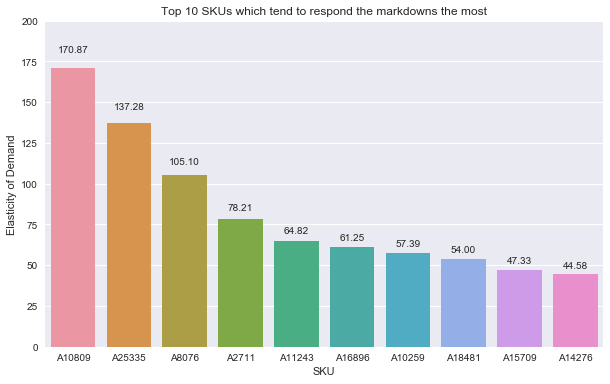

In [429]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x='SKU',y='Elasticity',data=data63[:10])
plt.ylabel('Elasticity of Demand')
plt.ylim(0,200)
plt.title('Top 10 SKUs which tend to respond the markdowns the most')
autolabel(ax)

<br><br>

### 4. Can we find any cross-sell and up-sell opportunites? <a name='11' />

**Metrics:** support, confidence, lift 

**Calculation Method:** For specific store, we can use association anlysis to find some relationships between 2 products, and use support, confidence, lift to know  the degree to which the antecedants' occurences are dependent on consequents' occurences. (Make sure to filter out orphan returns from the association analysis.) (There is no need to filter out the regular returns. Since when calculating sum of counts, it will cancel each other out.)


In [430]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [433]:
data_type = pd.read_csv('data_type.csv')
data_type.fillna('',inplace=True)

In [443]:
data_type[(data_type.TransactionID=='11-7270-00007-00089')&(data_type.SKU=='A21166')]

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
610,A29,11-7270-00007-00089,4,3995.000,1.000,3/11/12 00:00,A21166,
616,A29,11-7270-00007-00089,19,-3995.000,-1.000,3/11/12 00:00,A21166,Regular_Return
617,A29,11-7270-00007-00089,20,1995.000,1.000,3/11/12 00:00,A21166,


In [470]:
# Explore StoreID = A29
basket = data_type[data_type['StoreID']=='A29'].groupby(['TransactionID','SKU'])['Count'].sum().unstack().reset_index().fillna(0).set_index('TransactionID')

In [471]:
data_type[data_type['StoreID']=='A29'].groupby(['TransactionID','SKU'])['Count'].sum().head(10)

TransactionID        SKU   
11-7270-00005-00002  A5451    1.000
11-7270-00005-00003  A11687   1.000
                     A4654    1.000
11-7270-00005-00004  A13644   1.000
                     A21939   1.000
                     A25955   1.000
                     A43      1.000
                     A4595    1.000
                     A6499    1.000
                     A9562    1.000
Name: Count, dtype: float64

In [472]:
basket.head()

SKU,A1,A10004,A10006,A10007,A10008,A10016,A10023,A10024,A10025,A10045,...,A9933,A9938,A9941,A9942,A9946,A9947,A9963,A9964,A9981,A9982
TransactionID,,,,,,,,,,,,,,,,,,,,,
11-7270-00005-00002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
11-7270-00005-00003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
11-7270-00005-00004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
11-7270-00005-00005,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
11-7270-00005-00006,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [473]:
# Number of Transactions and Products
basket.shape

(4327, 4280)

In [474]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

In [475]:
frequent_itemsets = apriori(basket_sets, min_support=0.005, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedants,consequents,support,confidence,lift
0,(A3664),(A20874),0.162,0.054,1.912
1,(A20874),(A3664),0.028,0.309,1.912
2,(A25185),(A2052),0.020,0.314,26.125
3,(A2052),(A25185),0.012,0.519,26.125
4,(A2341),(A3664),0.026,0.277,1.713


#### For store=A29, rule: {A2052}-->{A25185}, 
- 1.2% support means 1.2% proportion of transactions in the dataset contain both A2052 and A25815;   
- 51.9% confidence means 51.9% who buy A2052 will also buy A25185.   
- Since lift=26.783, which lets us know the degree to which the antecedants' occurences are dependent on consequents' occurences. 

#### So we conclude item A25185 and A2052 have strong relationship.

<br><br>

### 5. How about the time or day of promotion? Would that make a difference? <a name='12' />


**Metrics:** Average sales per basket on transactions with discounted items and transactions without discounted items for SPECIFIC DATE

**Calculation Method:** 'Sum of sales / number of transactions' for  transactions with discounted items, and transactions without discounted items for SPECIFIC DATE. And then compare the average sales per basket. Also check whether promotions on different dates would make a difference. (When there is an orphan return, we simply exclude them when calculating sales per transaction)


In [75]:
data50.head(3)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
0,A29,11-7270-00007-00057,36,850.0,1.0,3/11/12 00:00,A21773,
1,A29,11-7270-00007-00057,39,1500.0,1.0,3/11/12 00:00,A18009,
2,A29,11-7270-00007-00057,40,1500.0,1.0,3/11/12 00:00,A25592,


In [76]:
# Select transactions with discounted items for specific store
q='''
  select
      Date,
      sum(Sales) as Total,
      count(distinct TransactionID) as Number_of_Transactions,
      sum(Sales)/count(distinct TransactionID) as 'Average sales per basket (with discounts)'
  from
      data50
  group by
      Date
  
  '''
data80= pysqldf(q)

In [78]:
data80

,Date,Total,Number_of_Transactions,Average sales per basket (with discounts)
0,3/11/12 00:00,5.129862e+07,4033,12719.717084
1,3/12/12 00:00,8.289848e+08,57045,14532.120491


In [79]:
# Select transactions with discounted items for specific store
q='''
  select
      Date,
      sum(Sales) as Total,
      count(distinct TransactionID) as Number_of_Transactions,
      sum(Sales)/count(distinct TransactionID) as 'Average sales per basket (without discounts)'
  from
      data52
  group by
      Date
  '''
data81= pysqldf(q)

In [80]:
data81

,Date,Total,Number_of_Transactions,Average sales per basket (without discounts)
0,3/11/12 00:00,3.453305e+07,4930,7004.674543
1,3/12/12 00:00,9.210454e+08,126955,7254.896943


In [93]:
np.arange(2)

array([0, 1])

In [113]:
def autolabel(rects):
    for rect in rects:
        height=rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2, 1.05*height, '{:.2f}'.format(height), ha='center', va='bottom')

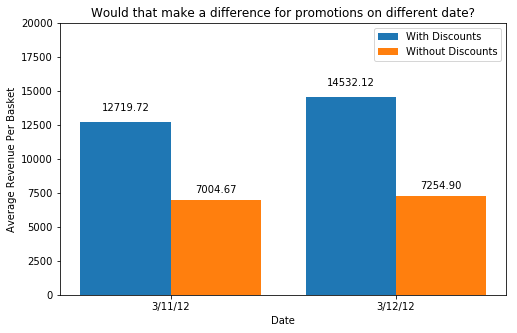

In [119]:
fig, ax = plt.subplots(figsize=(8,5))
#x=np.arange(2)
x=np.array([0,2])
width=0.05
rects1 = ax.bar(x,data80['Average sales per basket (with discounts)'])
rects2 = ax.bar(x+0.8,data81['Average sales per basket (without discounts)'])
ax.set_ylabel('Average Revenue Per Basket')
ax.set_xlabel('Date')
ax.set_ylim(0,20000)
ax.set_title('Would that make a difference for promotions on different date?')
ax.set_xticks(x+0.4)
ax.set_xticklabels(('3/11/12','3/12/12'))
ax.legend((rects1[0],rects2[0]),('With Discounts','Without Discounts'))
autolabel(rects1)
autolabel(rects2)

From the plot, the average revenue per basket for transactions with promotions is 82% higher than transactions without promotions on 3/11/12. And  the average revenue per basket for transactions with promotions is 100% higher than transactions without promotions on 3/12/12.

<br><br>

### 6. Look at low end and high end products separately when evaluating promotion strategy <a name='13' />


We define high end products are those whose regular unit price is bigger than \$5000. And low end products are those whose regular unit price is lower than $1000.

**Metrics:** Elasticity of Demand for specific SKU across stores

**Calculation Method:** Percent change in demand for specific SKU before and after discount / Percent change in price for specific SKU before and after discount

**Explanation:** I would make my own buckets and define which SKUs are high-end products, and which SKUs are low-end products. Then I would look at low end and high end produtcs separetely by calculating elasticity of demand for each SKU across stores.


In [171]:
# Select high end products
q='''
  select distinct SKU
  from data_type
  where Count>0 and Sales/Count>5000
  '''
data90= pysqldf(q)

In [132]:
data_type[data_type.SKU=='A22173'].head(3)

,StoreID,TransactionID,Line,Sales,Count,Date,SKU,Type
232,A29,11-7270-00008-00386,30,19900.0,1.0,3/11/12 00:00,A22173,
6378,A29,11-7270-00006-00053,1,19900.0,1.0,3/11/12 00:00,A22173,
11728,A29,11-7270-00006-00331,19,19900.0,1.0,3/11/12 00:00,A22173,


In [161]:
#SKUs with elasticity
data63.head()

,SKU,Elasticity
9,A10809,170.873253
209,A25335,137.281165
282,A8076,105.097126
219,A2711,78.205025
22,A11243,64.816423


In [174]:
q='''
  select b.*
  from data90 a
  join data63 b
  on a.SKU=b.SKU
  '''
data91= pysqldf(q)

In [183]:
data91

,SKU,Elasticity
0,A7883,38.473403
1,A8667,7.243721
2,A22535,5.868180


In [192]:
def autolabel(ax):
    for rect in ax.patches:
        height=rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2, 1.05*height, '{:.2f}'.format(height), ha='center', va='bottom')

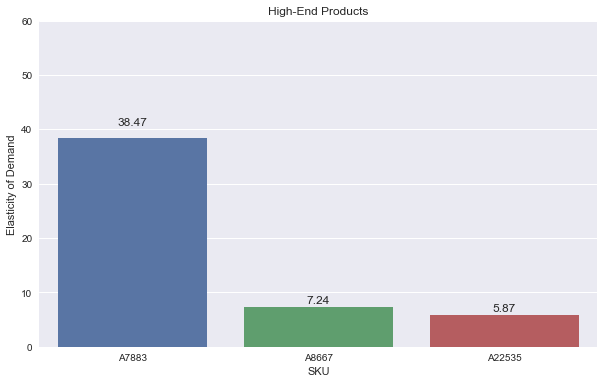

In [196]:
import seaborn as sns
plt.figure(figsize=(10,6))
ax = sns.barplot(x='SKU',y='Elasticity',data=data91)
plt.ylabel('Elasticity of Demand')
plt.ylim(0,60)
plt.title('High-End Products')
autolabel(ax)

For high-end products, the elasticity of demand ranged from 5.8 to 38.47, which means all of them are elastic.

<br>

In [178]:
# Select low end products
q='''
  select distinct SKU
  from data_type
  where Count>0 and Sales/Count<1000
  '''
data92= pysqldf(q)

In [179]:
q='''
  select b.*
  from data92 a
  join data63 b
  on a.SKU=b.SKU
  '''
data93= pysqldf(q)

In [185]:
print data91.shape #high-end products
print data93.shape #low-end products

(3, 2)
(64, 2)


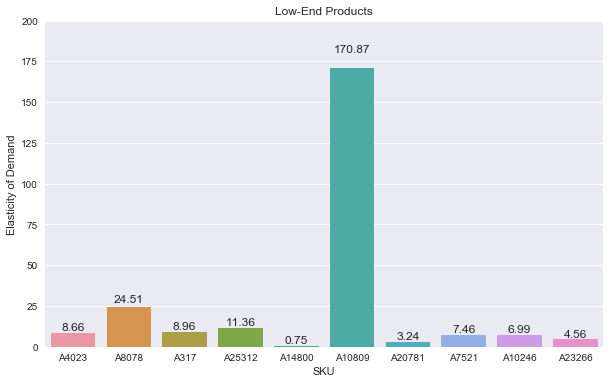

In [200]:
import seaborn as sns
plt.figure(figsize=(10,6))
ax = sns.barplot(x='SKU',y='Elasticity',data=data93[:10])
plt.ylabel('Elasticity of Demand')
plt.ylim(0,200)
plt.title('Low-End Products')
autolabel(ax)

In [189]:
data93.describe()

,Elasticity
count,64.000000
mean,14.667598
std,28.859059
min,0.067720
25%,2.260483
50%,4.427857
75%,14.005052
max,170.873253


For low-end products, the elasticity of demand ranged from 0.067 to 170.87, which means some products are inelastic and some are elastic.